In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from random import seed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from scipy.stats import bootstrap
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import math
from matplotlib.pyplot import figure
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from pandas import DataFrame,Series
from sklearn.ensemble import VotingClassifier

In [2]:
data = np.loadtxt('data.csv')
#shuffle the data and select training and test data
np.random.seed(100)
np.random.shuffle(data)
features = []
digits = []
for row in data:
    if(row[0]==1 or row[0]==5):
        features.append(row[1:])
        digits.append(str(row[0]))
#select the proportion of data to use for training
numTrain = int(len(features)*.8)
trainFeatures = features[:numTrain]
testFeatures = features[numTrain:]
trainDigits = digits[:numTrain]
testDigits = digits[numTrain:]

In [3]:
#2D features from HW1
X = list(np.mean(trainFeatures, axis=1))
maxnumx = max(X)

Y = []
for i in range(len(trainFeatures)):
    x = trainFeatures[i][0:128]
    y = trainFeatures[i][128:]
    Y.append(pearsonr(x,y)[0])
maxnumy = max(Y)

MeanCorrelation = np.column_stack((X, Y))

In [4]:
#color mapping
colors = []
for index in range(len(trainFeatures)):
    if(trainDigits[index]=="1.0"):
        colors.append("b")
    else:
        colors.append("r")

# Linear and Quadratic Discriminant Analysis

In [5]:
#LDA
model = LinearDiscriminantAnalysis()
fit_lda = model.fit(MeanCorrelation, trainDigits)

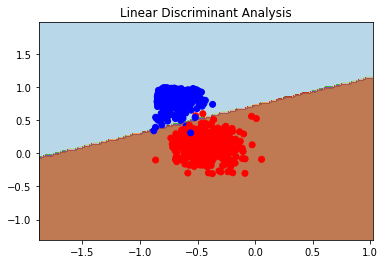

In [6]:
X = MeanCorrelation

def plotlda(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit_lda.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

plotlda('Linear Discriminant Analysis')

This decision boundary looks similar to the logistic regression decision boundary we did in homework 2, but it is not the same as they are performing different functions. Logistic regression is trying to solve maximum likelihood function while LDA is solving a least squares regression. Let's check the distribution of the multivariate sample $X$ and $Y$ to see if they are normally distributed.

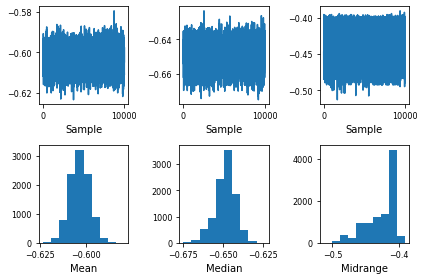

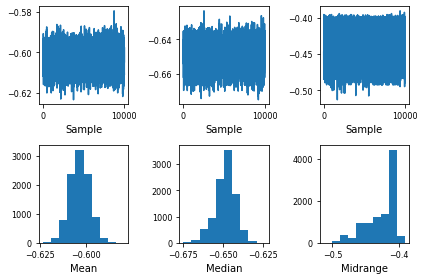

In [7]:
X_pd = pd.Series(MeanCorrelation[:,0])
pd.plotting.bootstrap_plot(X_pd, size=600, samples=10000)

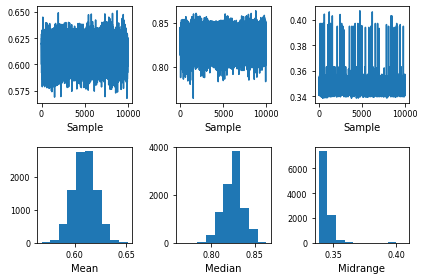

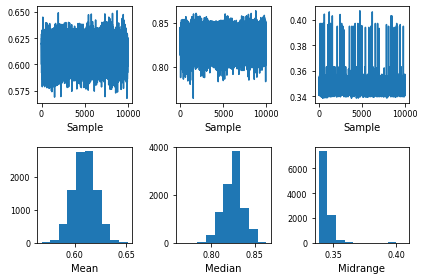

In [8]:
Y_pd = pd.Series(MeanCorrelation[:,1])
pd.plotting.bootstrap_plot(Y_pd, size=600, samples=10000)

From this we can see a normal bootstrap distribution, which reassures our assumption for the linear portion of LDA. This leads us to believe that the QDA will not perform as effectively as the LDA. 

In [9]:
##check if priors were calculated
count = 0
for i in range(len(colors)):
    if (colors[i]=="b"):
        count += 1

print("The percent of 1's in the list is", (count/len(colors))*100,"%")    
print(model.priors_)


The percent of 1's in the list is 64.50320512820514 %
[0.64503205 0.35496795]


In [10]:
#QDA
model = QuadraticDiscriminantAnalysis()
fit_qda = model.fit(MeanCorrelation, trainDigits)

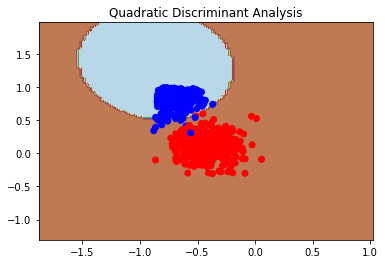

In [11]:
def plotqda(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit_qda.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

plotqda('Quadratic Discriminant Analysis')

Now let's check how our models perform using cross validation.

In [12]:
error_lda = 1 - np.mean(cross_val_score(fit_lda, MeanCorrelation, trainDigits, cv=10))
error_qda = 1 - np.mean(cross_val_score(fit_qda, MeanCorrelation, trainDigits, cv=10))
print("Error of LDA:", error_lda ,"Error of QDA:", error_qda)

Error of LDA: 0.005619354838709567 Error of QDA: 0.010412903225806458


Clearly, the QDA model looks worse on the decision boundary as it's overfitting and it also has double the error as LDA so we can conclude that the LDA model is superior.

# Decision Tree

In [13]:
numbers = [5, 10, 15, 20, 30, 40, 50, 75, 100, 200, 500, 1000, 10000]
errors = []
logNum = []

np.random.seed(100)
for i in numbers:
    model = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=i, min_samples_split=2)
    cross = cross_val_score(model, trainFeatures, trainDigits, cv=10)
    errors.append(1-np.mean(cross))
    logNum.append(math.log(i))

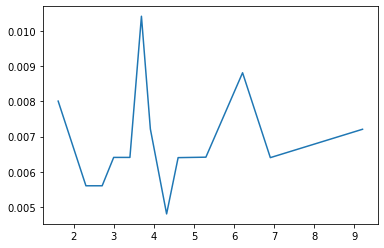

In [14]:
plt.plot(logNum, errors)

In [15]:
np.random.seed(100)
for i in numbers:
    model = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=i)
    fit = model.fit(trainFeatures, trainDigits)
    print(fit.get_n_leaves())

5
7
7
7
7
7
7
7
7
7
7
7
7


In [16]:
#lets find out what the value between 4 and 5 is
print(math.exp(4), 'number is between', math.exp(5))

54.598150033144236 number is between 148.4131591025766


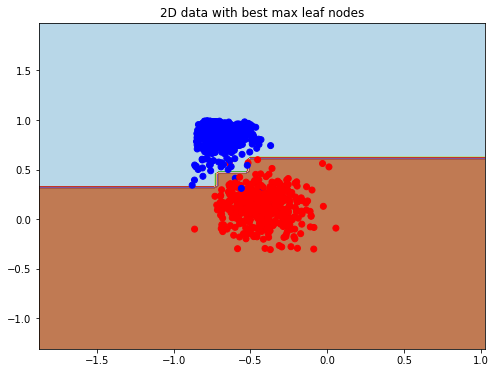

In [17]:
#closer to 4 so pick 75
model = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=75, min_samples_split=2)
fit_dt = model.fit(MeanCorrelation, trainDigits)

def plotdtc(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit_dt.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

figure(figsize=(8, 6))
plotdtc('2D data with best max leaf nodes')

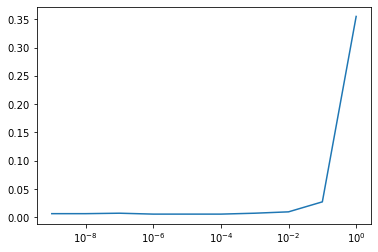

In [18]:
findNum = []
errors_pruning = []

for i in range(10):
    num = 10**-i
    findNum.append(num)
    
for j in findNum:
    model = DecisionTreeClassifier(criterion="entropy",  min_samples_split=2, min_impurity_decrease=j)
    cross = cross_val_score(model, trainFeatures, trainDigits, cv=10)
    errors_pruning.append(1-np.mean(cross))

plt.xscale('log')
plt.plot(findNum, errors_pruning)    

In [19]:
print(tabulate([findNum, errors_pruning],tablefmt="simple"))

--------  ---------  ---------  ------  ------  ------  ----------  ------  ------  ------
1         0.1        0.01       0.001   0.0001  1e-05   1e-06       1e-07   1e-08   1e-09
0.354968  0.0272774  0.0096129  0.0072  0.0056  0.0056  0.00560645  0.0072  0.0064  0.0064
--------  ---------  ---------  ------  ------  ------  ----------  ------  ------  ------


# Random Forest

In [20]:
scoresRand1 = []
scoresRand2 = []
scoresRand3 = []

mln = [10, 100, 1000]
estimators = [5,10,15,20,30,40,50,75,100,200,500]

np.random.seed(100)
for i in mln:
    for j in estimators:
        model1RF = RandomForestClassifier(max_leaf_nodes=i, criterion="entropy", n_estimators=j)
        fit1 = model1RF.fit(MeanCorrelation, trainDigits)
        cross1 = cross_val_score(fit1, MeanCorrelation, trainDigits, cv=10)
        if i == 10:
            scoresRand1.append(1-np.mean(cross1))        
        if i == 100:
            scoresRand2.append(1-np.mean(cross1))
        if i == 1000:
            scoresRand3.append(1-np.mean(cross1)) 

Text(0.5, 1.0, '10 Node Random Forest Cross Validation Error')

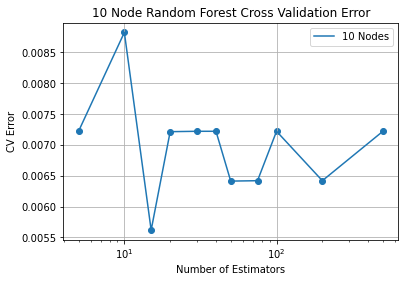

In [21]:
plt.xscale('log')
plt.scatter(estimators,scoresRand1)
plt.plot(estimators, scoresRand1, label='10 Nodes')
plt.legend()
plt.grid()
plt.ylabel('CV Error')
plt.xlabel('Number of Estimators')
plt.title('10 Node Random Forest Cross Validation Error')

In [22]:
print(tabulate([estimators, scoresRand1],tablefmt="simple"))

----------  -----------  -----------  ----------  -----------  -----------  ----------  -----------  ------------  ------------  ------------
5           10           15           20          30           40           50          75           100           200           500
0.00721935   0.00881935   0.00561935   0.0072129   0.00721935   0.00721935   0.0064129   0.00641935    0.00721935    0.00641935    0.00721935
----------  -----------  -----------  ----------  -----------  -----------  ----------  -----------  ------------  ------------  ------------


Text(0.5, 1.0, '100 Node Random Forest Cross Validation Error')

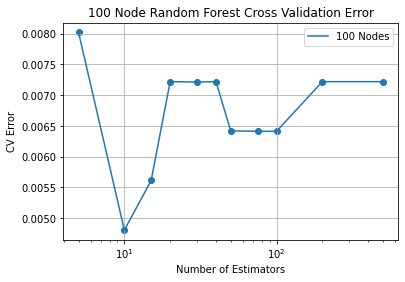

In [23]:
plt.xscale('log')
plt.scatter(estimators,scoresRand2)
plt.plot(estimators, scoresRand2, label='100 Nodes')  
plt.legend()
plt.grid()
plt.ylabel('CV Error')
plt.xlabel('Number of Estimators')
plt.title('100 Node Random Forest Cross Validation Error')

In [24]:
print(tabulate([estimators, scoresRand2],tablefmt="simple"))

----------  -----------  ----------  -----------  ----------  -----------  -----------  ----------  -----------  ------------  ------------
5           10           15          20           30          40           50           75          100          200           500
0.00801935   0.00480645   0.0056129   0.00721935   0.0072129   0.00721935   0.00641935   0.0064129    0.0064129    0.00721935    0.00721935
----------  -----------  ----------  -----------  ----------  -----------  -----------  ----------  -----------  ------------  ------------


Text(0.5, 1.0, '1000 Node Random Forest Cross Validation Error')

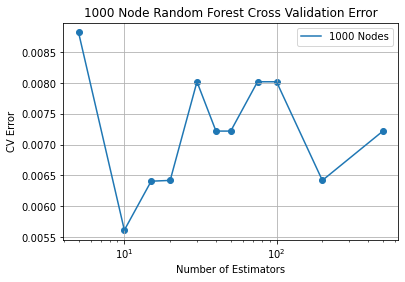

In [25]:
plt.xscale('log')
plt.scatter(estimators,scoresRand3)
plt.plot(estimators, scoresRand3, label='1000 Nodes')
plt.legend()
plt.grid()
plt.ylabel('CV Error')
plt.xlabel('Number of Estimators')
plt.title('1000 Node Random Forest Cross Validation Error')

In [26]:
print(tabulate([estimators, scoresRand3],tablefmt="simple"))

----------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  ------------  ------------  ------------
5           10          15           20           30           40           50           75           100           200           500
0.00881935   0.0056129   0.00640645   0.00641935   0.00801935   0.00721935   0.00721935   0.00801935    0.00801935    0.00641935    0.00721935
----------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  ------------  ------------  ------------


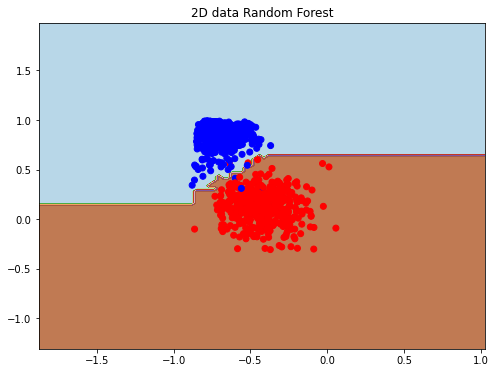

In [27]:
modelrf = RandomForestClassifier(max_leaf_nodes=100, criterion="entropy", n_estimators=10)
fit_rf = modelrf.fit(MeanCorrelation, trainDigits)

def plotrf(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit_rf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

figure(figsize=(8, 6))
plotrf('2D data Random Forest')

In [28]:
n = 12
error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, error11, error12 = [[] for _ in range(n)]

mln = [10, 100, 1000]
estimators = [1,10,100,1000]
features =  [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

np.random.seed(100)
for i in mln:
    for j in estimators:
        for k in features:
            model = RandomForestClassifier(max_leaf_nodes=i, criterion="entropy", n_estimators=j, max_features=k)
            fit = model.fit(trainFeatures, trainDigits)
            cross = cross_val_score(fit, MeanCorrelation, trainDigits, cv=10)
            if i == 10:
                if j == 1:
                    error1.append(1-np.mean(cross))
                if j == 10: 
                    error2.append(1-np.mean(cross))
                if j == 100:
                    error3.append(1-np.mean(cross))
                if j == 1000:
                    error4.append(1-np.mean(cross))
            if i == 100:
                if j == 1:
                    error5.append(1-np.mean(cross))
                if j == 10: 
                    error6.append(1-np.mean(cross))
                if j == 100:
                    error7.append(1-np.mean(cross))
                if j == 1000:
                    error8.append(1-np.mean(cross))
            if i == 1000:
                if j == 1:
                    error9.append(1-np.mean(cross))
                if j == 10: 
                    error10.append(1-np.mean(cross))
                if j == 100:
                    error11.append(1-np.mean(cross))
                if j == 1000: 
                    error12.append(1-np.mean(cross))

In [29]:
#10 max leaf nodes
error_stack1 = np.vstack((error1, error2, error3, error4))
error_10 = pd.DataFrame(error_stack1, estimators, features)

#100 max leaf nodes
error_stack2 = np.vstack((error5, error6, error7, error8))
error_100 = pd.DataFrame(error_stack2, estimators, features)

#1000 max leaf nodes
error_stack3 = np.vstack((error9, error10, error11, error12))
error_1000 = pd.DataFrame(error_stack2, estimators, features)


In [30]:
error_10

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
1,0.030413,0.015239,0.022432,0.028813,0.015232,0.014432,0.016019,0.016019,0.015213,0.008019
10,0.007213,0.005613,0.004806,0.006419,0.005613,0.005606,0.006413,0.007213,0.006413,0.008019
100,0.008019,0.006413,0.007219,0.007219,0.007219,0.006419,0.006419,0.006419,0.007219,0.008819
1000,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.008819


In [31]:
error_100

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
1,0.010419,0.008813,0.017619,0.009619,0.012819,0.008819,0.014426,0.007206,0.006413,0.011213
10,0.006413,0.005613,0.005613,0.007213,0.008019,0.007213,0.006413,0.006413,0.005613,0.006413
100,0.006419,0.007219,0.007219,0.005613,0.007219,0.005606,0.006419,0.007219,0.007219,0.009619
1000,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.008019


In [32]:
error_1000

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
1,0.010419,0.008813,0.017619,0.009619,0.012819,0.008819,0.014426,0.007206,0.006413,0.011213
10,0.006413,0.005613,0.005613,0.007213,0.008019,0.007213,0.006413,0.006413,0.005613,0.006413
100,0.006419,0.007219,0.007219,0.005613,0.007219,0.005606,0.006419,0.007219,0.007219,0.009619
1000,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.007219,0.008019


# AdaBoost

In [33]:
ada_estimators = [1,5,10,100,1000,10000]
ada_error = []

np.random.seed(100)
for i in ada_estimators:
    model = AdaBoostClassifier(n_estimators=i)
    fit_ada = model.fit(trainFeatures, trainDigits)
    cross = cross_val_score(fit_ada, trainFeatures, trainDigits, cv=10)
    ada_error.append(1-np.mean(cross))

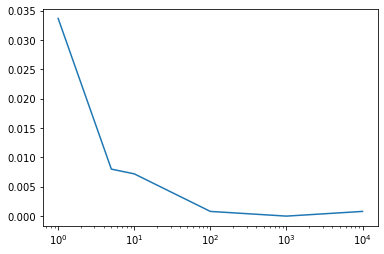

In [34]:
plt.xscale('log')
plt.plot(ada_estimators, ada_error)

In [35]:
print(tabulate([ada_estimators, ada_error],tablefmt="simple"))

---------  ----------  -------  --------  ----  ----------
1          5           10       100       1000  10000
0.0336774  0.00800645   0.0072    0.0008     0      0.0008
---------  ----------  -------  --------  ----  ----------


In [36]:
ada_error_10 = []

np.random.seed(100)
for i in ada_estimators:
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=i)
    fit_ada = model.fit(trainFeatures, trainDigits)
    cross = cross_val_score(fit_ada, trainFeatures, trainDigits, cv=10)
    ada_error_10.append(1-np.mean(cross))

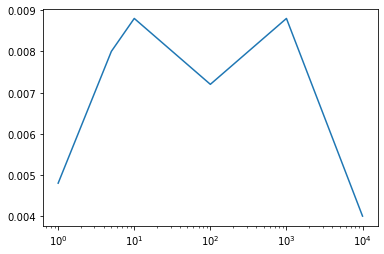

In [37]:
plt.xscale('log')
plt.plot(ada_estimators, ada_error_10)

In [38]:
ada_error_1000 = []

np.random.seed(100)
for i in ada_estimators:
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1000),n_estimators=i)
    fit_ada = model.fit(trainFeatures, trainDigits)
    cross = cross_val_score(fit_ada, trainFeatures, trainDigits, cv=10)
    ada_error_1000.append(1-np.mean(cross))

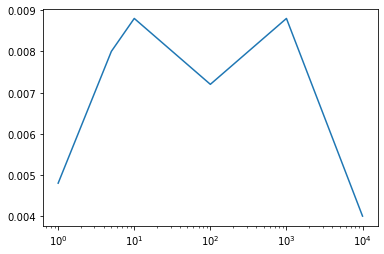

In [39]:
plt.xscale('log')
plt.plot(ada_estimators, ada_error_1000)

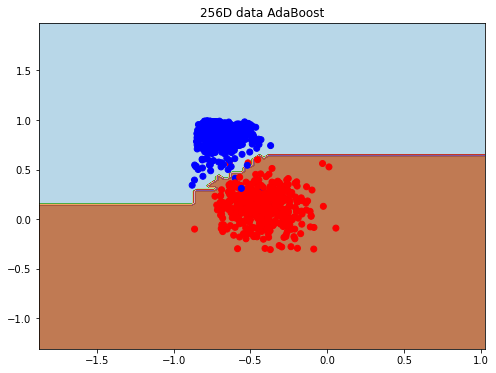

In [40]:
modelada = AdaBoostClassifier(n_estimators=1000)
fit_ada = modelada.fit(trainFeatures, trainDigits)

def plotada(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit_ada.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

figure(figsize=(8, 6))
plotrf('256D data AdaBoost')

# Model Ensemble

In [41]:
cList = np.arange(0.01, 50, 0.25)
cResults = []

for i in cList:
    clf_log = LogisticRegression(penalty='l2', C=i)
    fit_log = clf_log.fit(MeanCorrelation, trainDigits) 
    scores = cross_val_score(fit_log, MeanCorrelation, trainDigits, cv=10, scoring='accuracy')
    cResults.append(1 - scores.mean())

In [42]:
min_val = min(cResults)
cList[cResults.index(min_val)]

0.26

In [43]:
#logistic
clf_log = LogisticRegression(penalty='l2', C=0.26)
fit_log = clf_log.fit(MeanCorrelation, trainDigits)

#polySVM
clf_svm = svm.SVC(C=1.26, kernel='poly', degree = 5)
fit_svm = clf_svm.fit(MeanCorrelation, trainDigits)

#RandomForest
modelrf = RandomForestClassifier(max_leaf_nodes=100, criterion="entropy", n_estimators=10)
fit_rf = modelrf.fit(MeanCorrelation, trainDigits)

#AdaBoost
modelada = AdaBoostClassifier(n_estimators=1000)
fit_ada = modelada.fit(MeanCorrelation, trainDigits)

In [45]:
X_test = list(np.mean(testFeatures, axis=1))
maxnumx = max(X_test)

Y_test = []
for i in range(len(testFeatures)):
    x = testFeatures[i][0:128]
    y = testFeatures[i][128:]
    Y_test.append(pearsonr(x,y)[0])
maxnumy = max(Y_test)

MeanCorrelation_test = np.column_stack((X_test, Y_test))

train_error = []
test_error = []

#training set
train_yhat = fit_log.predict(MeanCorrelation)
train_acc = accuracy_score(trainDigits, train_yhat)
train_error.append(1-train_acc)
train_yhat = fit_svm.predict(MeanCorrelation)
train_acc = accuracy_score(trainDigits, train_yhat)
train_error.append(1-train_acc)
train_yhat = fit_rf.predict(MeanCorrelation)
train_acc = accuracy_score(trainDigits, train_yhat)
train_error.append(1-train_acc)
train_yhat = fit_ada.predict(MeanCorrelation)
train_acc = accuracy_score(trainDigits, train_yhat)
train_error.append(1-train_acc)


# evaluate on the test dataset
test_yhat = fit_log.predict(MeanCorrelation_test)
test_acc = accuracy_score(testDigits, test_yhat)
test_error.append(1-test_acc)   
test_yhat = fit_svm.predict(MeanCorrelation_test)
test_acc = accuracy_score(testDigits, test_yhat)
test_error.append(1-test_acc)  
test_yhat = fit_rf.predict(MeanCorrelation_test)
test_acc = accuracy_score(testDigits, test_yhat)
test_error.append(1-test_acc) 
test_yhat = fit_ada.predict(MeanCorrelation_test)
test_acc = accuracy_score(testDigits, test_yhat)
test_error.append(1-test_acc)  
    
col={'Train Error':train_error,'Test Error':test_error}
models=['Regularized Logistic Regression \n C=0.26','Polynomial SVM \n Degree=5 \n C=1.26','Random Forest \n n_estimators=10 \n max_leaf_nodes=100','AdaBoost \n Depth=1 \n n_estimators=1000']
df=DataFrame(data=col,index=models)


<AxesSubplot:>

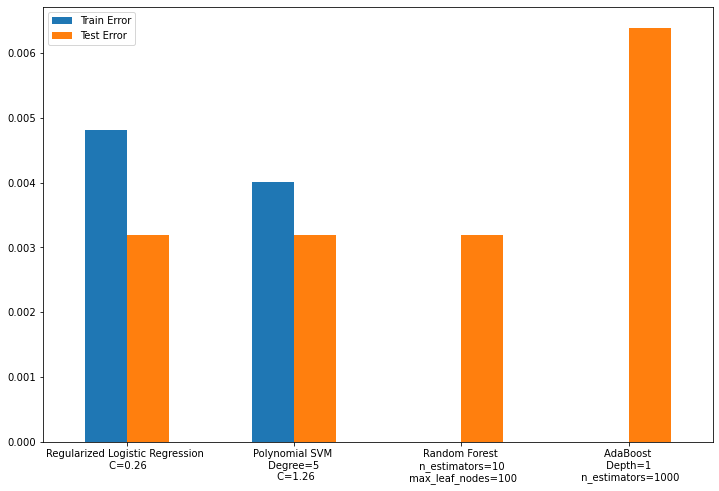

In [46]:
df.plot(kind='bar', rot=0, figsize=(12, 8))

<AxesSubplot:>

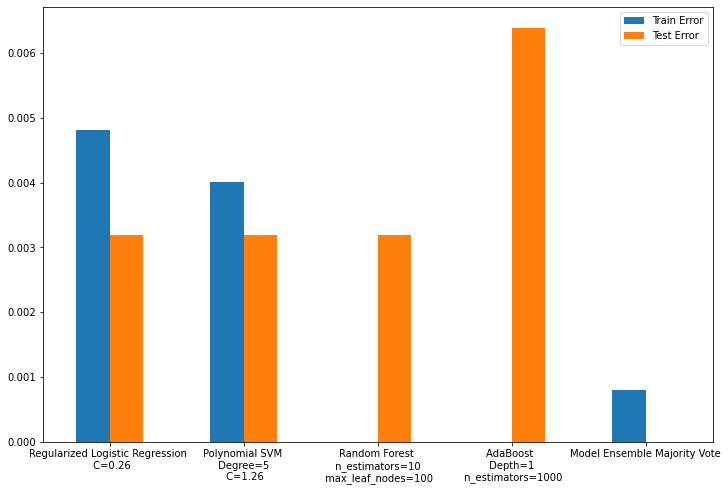

In [47]:
model_ensemble = VotingClassifier(estimators=[('log', fit_log), ('svm', fit_svm), ('rf', fit_rf), ('ada', fit_ada)], voting='hard')
fit_ensemble = model_ensemble.fit(MeanCorrelation, trainDigits)
train_yhat = fit_ensemble.predict(MeanCorrelation)
train_acc = accuracy_score(trainDigits, train_yhat)
train_error.append(1-train_acc)
test_yhat = fit_ensemble.predict(MeanCorrelation_test)
test_acc = accuracy_score(testDigits, test_yhat)
test_error.append(1-test_acc)  

col={'Train Error':train_error,'Test Error':test_error}
models=['Regularized Logistic Regression \n C=0.26','Polynomial SVM \n Degree=5 \n C=1.26','Random Forest \n n_estimators=10 \n max_leaf_nodes=100','AdaBoost \n Depth=1 \n n_estimators=1000', 'Model Ensemble Majority Vote']
df=DataFrame(data=col,index=models)

df.plot(kind='bar', rot=0, figsize=(12, 8))

In [48]:
train_error

[0.004807692307692291, 0.004006410256410242, 0.0, 0.0, 0.0008012820512820484]